In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import  Adam
import tensorflow as tf
import cv2
import numpy as np
from PIL import Image
from tensorflow.keras.models import load_model
import os


In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, vertical_flip=True, fill_mode='nearest')

train_dir = "/Users/rushikesh/Desktop/Jay/vscode_foml/project/facedata/"
target_size = (224,224)
batch_size = 32

train_generators = train_datagen.flow_from_directory(train_dir, target_size=target_size, batch_size=batch_size,class_mode='binary')

In [ ]:
model = Sequential()
model.add(Conv2D(64,(3,3),activation='relu',input_shape=(224,224,3)))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(256,(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

model.summary()

In [62]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'] )

In [ ]:
hist = model.fit(train_generators,epochs=8)

In [ ]:
from mtcnn import MTCNN
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image
import cv2
import matplotlib.pyplot as plt

# Load your pre-trained face classification model

# Initialize the MTCNN detector
detector = MTCNN()

def show_annotated_faces(image_path):
    # Load the image
    image = Image.open(image_path)
    image_rgb = image.convert('RGB')  # Ensure RGB format for face detection
    image_array = np.array(image_rgb)
  
    # Detect faces
    faces = detector.detect_faces(image_array)
    
    # Convert image to OpenCV format for bounding box drawing
    image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    
    for i, face in enumerate(faces):
        x, y, width, height = face['box']
        
        # Crop each detected face
        face_crop = image_array[y:y+height, x:x+width]
        face_image = Image.fromarray(face_crop).resize((224, 224))  # Resize to model's input size
        
        # Preprocess the face image for prediction
        face_array = img_to_array(face_image) / 255.0  # Scale to [0, 1]
        face_array = np.reshape(face_array, (1,224,224,3))  # Add batch dimension
        
        # Predict using the loaded model
        prediction = newmodel.predict(face_array)
        
        # Define the label and color for the bounding box
        if prediction[0][0] > 0.7:  # Assuming output close to 1 means your face
            label = "My Face"
            color = (0, 255, 0)  # Green for your face
        else:
            label = "Other"
            color = (0, 0, 255)  # Red for others

        # Draw bounding box and label on the image
        cv2.rectangle(image_cv, (x, y), (x + width, y + height), color, 2)
        cv2.putText(image_cv, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    
    # Convert BGR image back to RGB for displaying with matplotlib
    image_rgb = cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB)
    
    # Show the image with matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(image_rgb)
    plt.axis('off')  # Hide axes
    plt.show()

# Test with an image
image_path = '/Users/rushikesh/Desktop/Jay/vscode_foml/group.jpeg'
show_annotated_faces(image_path)


In [90]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import load_model


base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model's weights

newmodel = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

newmodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
import shutil
import os

# Define the source path (location of the downloaded file)
source_path = "/Users/rushikesh/Desktop/Jay/vscode_foml/project/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"

# Define the destination path (Keras models directory)
destination_dir = os.path.join(os.path.expanduser("~"), ".keras", "models")
os.makedirs(destination_dir, exist_ok=True)  # Create the directory if it doesn't exist

# Move the file
shutil.move(source_path, destination_dir)
print(f"File moved to: {destination_dir}")



In [ ]:
newmodel.summary()

In [ ]:
hist = newmodel.fit(train_generators,epochs=10)

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from mtcnn import MTCNN
import matplotlib.pyplot as plt

# Initialize the face detector and load the trained model
detector = MTCNN()

def identify_my_face(image_path, model, threshold=0.5):
    # Load and preprocess the image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Detect faces in the image
    faces = detector.detect_faces(image_rgb)
    for face in faces:
        x, y, width, height = face['box']
        x, y = abs(x), abs(y)
        
        # Extract the face ROI (Region of Interest) and preprocess it
        face_img = image_rgb[y:y+height, x:x+width]
        face_resized = cv2.resize(face_img, (224, 224))
        face_array = img_to_array(face_resized)
        face_array = np.expand_dims(face_array, axis=0)
        face_array = preprocess_input(face_array)

        # Predict if the face is yours
        prediction = model.predict(face_array)[0][0]

        # If prediction exceeds threshold, label it as your face
        if prediction >= threshold:
            label = "My Face"
            color = (0, 255, 0)  # Green for your face
        else:
            label = "Not My Face"
            color = (255, 0, 0)  # Red for others

        # Draw bounding box and label on the original image
        cv2.rectangle(image_rgb, (x, y), (x + width, y + height), color, 2)
        cv2.putText(image_rgb, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    # Display the result
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()

# Example usage
image_path = '/Users/rushikesh/Desktop/Jay/vscode_foml/group4.jpeg'
identify_my_face(image_path, newmodel)


In [ ]:
from keras_vggface import VGGFace
# from keras_vggface.utils import preprocess_input

base_model = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')
base_model.trainable = False

vggmodel = Sequential([
    base_model,
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

vggmodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

import keras
print("Keras version:", keras.__version__)


In [ ]:
import tensorflow as tf
# import tensorflow_hub as hub

from keras_facenet import FaceNet

# Create an instance of the FaceNet model
facenet_model = FaceNet()


# Load the FaceNet model from TensorFlow Hub


# Function to encode images
def preprocess_and_generate_embeddings(image_paths):
    embeddings = []

    for image_path in image_paths:
        img = tf.io.read_file(image_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, [160, 160])  # Resize to 160x160 for FaceNet
        img = img / 255.0  # Normalize to [0, 1]
        img = tf.expand_dims(img, axis=0)  # Add batch dimension
        
        # Generate the embedding
        embedding = facenet_model(img)
        embeddings.append(embedding.numpy())

    return embeddings

# Assuming you have a folder with images
image_folder = '/Users/rushikesh/Desktop/Jay/vscode_foml/project/facedata/jay'
image_paths = [os.path.join(image_folder, img) for img in os.listdir(image_folder) if img.endswith('.jpg')]

# Generate embeddings
embeddings = preprocess_and_generate_embeddings(image_paths)

# Convert list of embeddings to a numpy array for further use
embeddings = np.array(embeddings)


In [ ]:
import os
import cv2
import numpy as np
from keras_facenet import FaceNet

# Load the FaceNet model
facenet_model = FaceNet()

# Function to preprocess and get embeddings
def get_face_embedding(image_path):
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Image not found at path: {image_path}")
    
    # Convert the image to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Resize the image to the expected input size
    image_resized = cv2.resize(image_rgb, (160, 160))  # FaceNet input size
    # Normalize the image
    image_normalized = image_resized.astype('float32') / 255.0
    # Expand dimensions to match the model input shape
    image_expanded = np.expand_dims(image_normalized, axis=0)

    # Get the face embeddings
    embedding = facenet_model.embeddings(image_expanded)  # Use the embeddings method
    return embedding[0]  # Return the first (and only) embedding

# Folder containing your cropped face images
folder_path = '/Users/rushikesh/Desktop/Jay/vscode_foml/project/facedata/jay'  # Update with your folder path

# List to store embeddings
embeddings_list = []

# Iterate through the images in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(('.jpg', '.jpeg', '.png')):  # Check for image file types
        image_path = os.path.join(folder_path, filename)
        try:
            # Get the embedding for each image
            embedding = get_face_embedding(image_path)
            embeddings_list.append(embedding)
            print(f"Processed {filename}, embedding shape: {embedding.shape}")
        except Exception as e:
            print(f"Error processing {filename}: {e}")

# Convert the list of embeddings to a NumPy array for further use
embeddings_array = np.array(embeddings_list)
print("Generated embeddings for all images:")
print(embeddings_array)


In [ ]:
import os
import cv2
import numpy as np
from keras_facenet import FaceNet
from mtcnn.mtcnn import MTCNN

# Load the FaceNet model for embeddings
facenet_model = FaceNet()

# Initialize MTCNN for face detection
detector = MTCNN()

# Function to get the face embeddings from an image
def get_face_embedding(image):
    # Resize and normalize the image
    image_resized = cv2.resize(image, (160, 160))
    image_normalized = image_resized.astype('float32') / 255.0
    image_expanded = np.expand_dims(image_normalized, axis=0)

    # Get the face embeddings
    embedding = facenet_model.embeddings(image_expanded)
    return embedding[0]  # Return the first (and only) embedding

# Function to detect faces and draw bounding boxes
def detect_faces_and_predict(image_path, my_embeddings):
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Image not found at path: {image_path}")

    # Detect faces in the image
    faces = detector.detect_faces(image)
    
    # Loop over the detected faces
    for face in faces:
        x, y, width, height = face['box']
        bounding_box = (x, y, x + width, y + height)

        # Extract the face from the image
        face_image = image[y:y + height, x:x + width]
        
        # Get the embedding for the detected face
        face_embedding = get_face_embedding(face_image)
        
        # Calculate the distance to my face embedding (L2 distance)
        distance = np.linalg.norm(my_embeddings - face_embedding)
        
        # Set a threshold to decide if it's the same person
        threshold = 0.6  # This can be adjusted based on your results
        
        # Draw bounding box and label
        if distance < threshold:
            label = "My Face"
        else:
            label = "Not Me"

        # Draw bounding box
        cv2.rectangle(image, (x, y), (x + width, y + height), (255, 0, 0), 2)
        cv2.putText(image, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36, 255, 12), 2)

    # Show the output image
    cv2.imshow('Faces', image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# Generate embeddings for your own face images
my_folder_path = '/Users/rushikesh/Desktop/Jay/vscode_foml/project/facedata/jay'  # Update with your folder path
my_embeddings_list = []

# Iterate through your images to generate your embeddings
for filename in os.listdir(my_folder_path):
    if filename.endswith(('.jpg', '.jpeg', '.png')):
        image_path = os.path.join(my_folder_path, filename)
        try:
            image = cv2.imread(image_path)
            embedding = get_face_embedding(image)
            my_embeddings_list.append(embedding)
        except Exception as e:
            print(f"Error processing {filename}: {e}")

# Average the embeddings for a more robust representation of your face
my_embeddings = np.mean(my_embeddings_list, axis=0)

# Test the model on an image with multiple faces
test_image_path = '/Users/rushikesh/Desktop/Jay/vscode_foml/group2.jpeg'  # Update with your test image path
detect_faces_and_predict(test_image_path, my_embeddings)


In [ ]:
my_embeddings = my_embeddings_list[0]

# Test the model on an image with multiple faces
test_image_path = '/Users/rushikesh/Desktop/Jay/vscode_foml/notme.jpeg'  # Update with your test image path
detect_faces_and_predict(test_image_path, my_embeddings)

In [2]:
import numpy as np
import cv2
import os
from sklearn.svm import SVC
from keras_facenet import FaceNet
from mtcnn import MTCNN
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Initialize FaceNet and MTCNN
embedder = FaceNet()
detector = MTCNN()

# Step 1: Load and Generate Embeddings for Your Face Dataset
face_embeddings = []
labels = []

folder = '/Users/rushikesh/Desktop/Jay/vscode_foml/project/facedata/jay'

# Assuming 'your_face_folder' contains cropped images of your face
for filename in os.listdir(folder):
    if filename.endswith(('.jpg', '.jpeg', '.png')):
        img_path = os.path.join(folder, filename)
        try:
            image = cv2.imread(img_path)
            image_resized = cv2.resize(image, (160, 160))
            image_normalized = image_resized.astype('float32') / 255.0
            image_resized = np.expand_dims(image_resized, axis=0)
            embedding = embedder.embeddings(image_resized)[0]
            face_embeddings.append(embedding)
            labels.append(1)  # Label '1' for your face
        except Exception as e:
            print(f"Error processing {filename}: {e}")
    
notMyFaceFolder = '/Users/rushikesh/Desktop/Jay/vscode_foml/project/facedata/notjay_cropped'
# Optionally, add embeddings for negative samples (not your face)
for filename in os.listdir(notMyFaceFolder):
    if filename.endswith(('.jpg', '.jpeg', '.png')):
        img_path = os.path.join(notMyFaceFolder, filename)
        try:
            image = cv2.imread(img_path)
            image_resized = cv2.resize(image, (160, 160))
            image_normalized = image_resized.astype('float32') / 255.0
            image_resized = np.expand_dims(image_resized, axis=0)
            embedding = embedder.embeddings(image_resized)[0]
            face_embeddings.append(embedding)
            labels.append(0)  # Label '0' for not your face
        except Exception as e:
            print(f"Error processing {filename}: {e}")

# Convert to numpy arrays
face_embeddings = np.array(face_embeddings)
labels = np.array(labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━

In [3]:
# Step 2: Train an SVM Classifier
X_train, X_test, y_train, y_test = train_test_split(face_embeddings, labels, test_size=0.2, random_state=42)
svm = SVC(kernel='linear', probability=True)
svm.fit(X_train, y_train)

# Evaluate SVM
y_pred = svm.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, y_pred))




SVM Accuracy: 0.9785276073619632


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


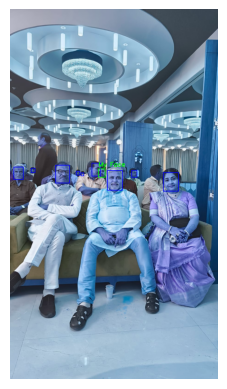

Your face was found in the image!


In [20]:
# Step 3: Test on an Image with Multiple Faces
import matplotlib.pyplot as plt
test_image_path = '/Users/rushikesh/Desktop/Jay/vscode_foml/test/WhatsApp Image 2024-11-07 at 6.49.29 PM.jpeg'
test_image = cv2.imread(test_image_path)
test_image_rgb = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

# Detect faces in the test image
faces = detector.detect_faces(test_image_rgb)

found_my_face = False

for face in faces:
    x, y, w, h = face['box']
    face_crop = test_image_rgb[y:y+h, x:x+w]  # Crop face region

    # Resize and generate embedding for each face in test image
    face_crop_resized = cv2.resize(face_crop, (160, 160))
    face_crop_resized = np.expand_dims(face_crop_resized, axis=0)
    face_embedding = embedder.embeddings(face_crop_resized)[0]

    # Use SVM to predict if the face is yours
    prediction = svm.predict([face_embedding])
    if prediction == 1:
        found_my_face = True
        cv2.rectangle(test_image, (x, y), (x+w, y+h), (0, 255, 0), 2)  # Bounding box in green
        cv2.putText(test_image, "My Face", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    else:
        cv2.rectangle(test_image, (x, y), (x+w, y+h), (0, 0, 255), 2)  # Bounding box in red

# Display result
plt.imshow(test_image)
plt.axis('off')
plt.show()


if found_my_face:
    print("Your face was found in the image!")
else:
    print("Your face was not found in the image.")